In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fftpack import fft
from scipy import signal

In [5]:
arr = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
arr_r = np.reshape(arr, (2, 5))
df = pd.DataFrame(arr_r)
df

,0,1,2,3,4
0,1,2,3,4,5
1,6,7,8,9,10


In [26]:
arr_r[:,0]

array([1, 6])

In [23]:
t = np.split(arr_r, 2, axis=0)
t

[array([[1, 2, 3, 4, 5]]), array([[ 6,  7,  8,  9, 10]])]

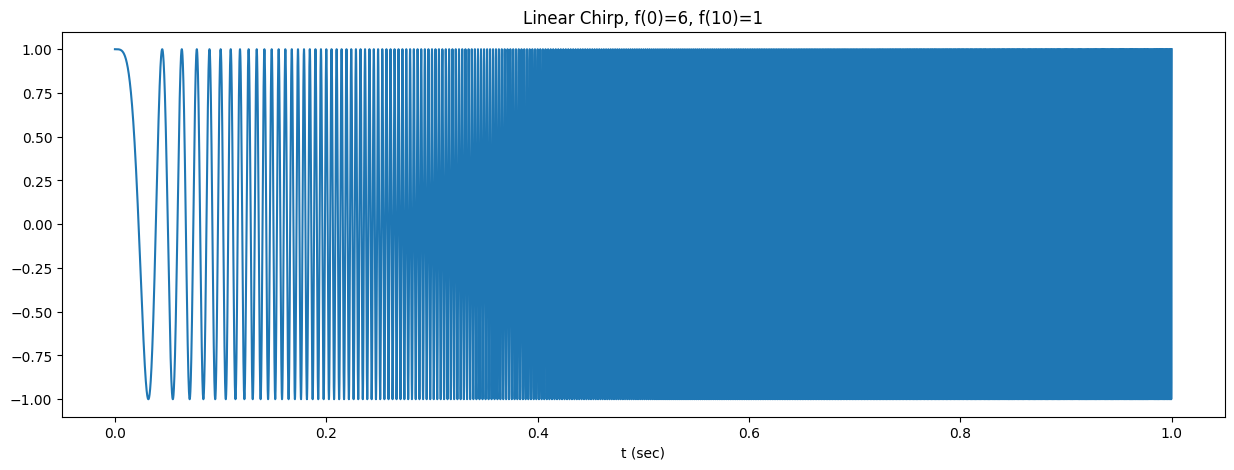

In [67]:
t = np.linspace(0, 1, 100000)
w = signal.chirp(t, f0=0, f1=1000, t1=1, method='linear')
plt.figure(figsize=(15, 5))
plt.plot(t, w)

plt.title("Linear Chirp, f(0)=6, f(10)=1")
plt.xlabel('t (sec)')
plt.show()

In [70]:
fs = 7200
T = 4
t = np.arange(0, int(T*fs)) / fs

In [76]:
def plot_spectrogram(title, w, fs):
    ff, tt, Sxx = signal.spectrogram(w, fs=fs, nperseg=256, nfft=576)
    plt.pcolormesh(tt, ff[:145], Sxx[:145], cmap='gray_r', shading='gouraud')
    plt.title(title)
    plt.xlabel('t (sec)')
    plt.ylabel('Frequency (Hz)')
    plt.grid()

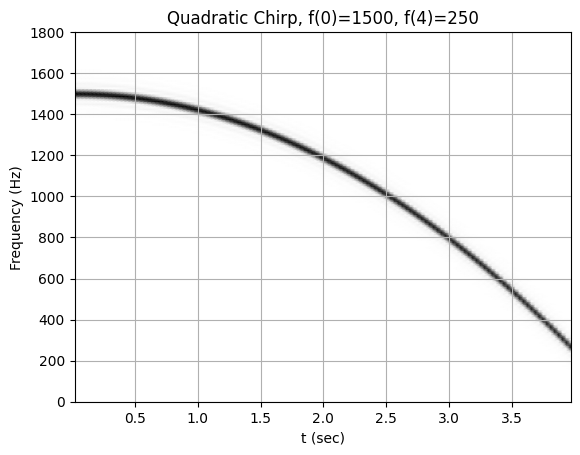

In [77]:
w = signal.chirp(t, f0=1500, f1=250, t1=T, method='quadratic')
plot_spectrogram(f'Quadratic Chirp, f(0)=1500, f({T})=250', w, fs)
plt.show()

In [ ]:
c = 299792458


In [ ]:
# chirp sequence frequency
f_chirp = 50*1e3 #Hz

# ramp frequency
f_r = 200*1e6 #Hz
T_r = 1/f_chirp # duration of one cycle
m_w = f_r/T_r

n_r = 150 # number of chirps
T_M = T_r*n_r

In [ ]:
# sample settings
f_s = 50e6 #50 MHz
n_s = int(T_r*f_s)

In [ ]:
f_0 = 77.7*1e9

# some helpful
w_0 = 2*np.pi*f_0
lambda_0 = c/f_0

In [ ]:
def f_transmitted(t):
    return f_0 + m_w*(t%T_r)

In [ ]:
def chirp(t):
    return np.cos(2*np.pi*(f_transmitted(t))*t)

In [ ]:
1e6

In [ ]:
t = np.linspace(0, 3*T_r, int(1e6))


In [ ]:
plt.figure(figsize=(15,5))
plt.plot(t, f_transmitted(t))
plt.xlabel("t [s]")
plt.ylabel("frequency [Hz]")
plt.title("Chirp sequence Modulation, transmitted signal $f_t(t)$");

In [ ]:
r_0 = 50 # initial distance
v_veh = 36/3.6 # velocity

In [ ]:
def get_range(t):
    return r_0+v_veh*t

In [ ]:
4*np.pi*100*f_0/c, 2*np.pi*(2*100/c)**2*m_w

In [ ]:
def itr(t):
    r = get_range(t)
    w_itr = 2*f_0*v_veh/c + 2*m_w*r/c
    # we do t%T_r because the eq. above only valid within the ramp
    v = np.cos(2*np.pi*w_itr*(t%T_r) +2*r*2*np.pi*f_0/c)
    return v

In [ ]:
print(n_r, n_s)


In [ ]:
t_sample = np.linspace(0, T_M, n_r*n_s)


In [ ]:
v_sample = itr(t_sample)



In [ ]:
v_sample

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(t_sample, v_sample)
plt.xlim(0, 1e-4)
plt.xlabel("t [s]")
plt.title("Samples visualized in time range [0, 10% $T_r$]");

In [ ]:
table = np.zeros((n_r, n_s))


In [ ]:
for chirp_nr in range(n_r):
    table[chirp_nr, :] = v_sample[(chirp_nr*n_s):(n_s*(chirp_nr+1))]

In [ ]:
table_df = pd.DataFrame(data=table, 
                        columns=["sample_%03d"%i for i in range(n_s)], 
                        index=["chirp_%03d"%i for i in range(n_r)])

In [ ]:
table_df.head(10)


In [ ]:
chirp0_samples = table_df.iloc[0].values


In [ ]:
len(chirp0_samples)

In [ ]:
chirp0_magnitude = fft(chirp0_samples)


In [ ]:
frequencies = np.arange(0, n_s//2)*f_s/n_s


In [ ]:
f_star1 = 2*m_w/c*100
f_star2 = 2*f_0/c*33
print(f_star1, f_star2)
print(f_star2/f_star1*100, "%")

In [ ]:
def freq_to_range(f):
    return f*c/(2*m_w)

In [ ]:
ranges = freq_to_range(frequencies)


In [ ]:
plt.figure(figsize=(10,5))
plt.plot(ranges, 2.0/n_s*np.abs(chirp0_magnitude[0:n_s//2]))
plt.plot(ranges, 2.0/n_s*np.abs(chirp0_magnitude[0:n_s//2]), "k+")
plt.xlabel("range $r$ [m]")
plt.title("derived range (FFT of chirp_0)")
print(freq_to_range(frequencies)[np.argmax(2.0/n_s*np.abs(chirp0_magnitude[0:n_s//2]))])

In [ ]:
range_table = np.zeros((n_r, n_s//2), dtype=np.csingle)


In [ ]:
for chirp_nr in range(n_r):
    chirp_ad_values = table_df.iloc[chirp_nr].values
    chirp_fft = fft(chirp_ad_values) # FFT
    range_table[chirp_nr, :] = 2.0/n_s*chirp_fft[:n_s//2]

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10), sharex=True, sharey=True)
abs_axes = ax[0, 0]
phi_axes = ax[0, 1]
real_axes = ax[1, 0]
imag_axes = ax[1, 1]

im_asb = abs_axes.imshow(np.abs(range_table), cmap = plt.get_cmap('RdYlBu'))
abs_axes.set_xticks(range(ranges.size)[::50])
abs_axes.set_xticklabels(ranges[::50], rotation=90)
fig.colorbar(im_asb, ax=abs_axes)
abs_axes.set_xlabel("range [m]")
abs_axes.set_ylabel("chirp number")
abs_axes.set_title("$|A(j\omega)|$")

im_phi = phi_axes.imshow(np.angle(range_table)*360/(2*np.pi), cmap = plt.get_cmap('RdYlBu'))
fig.colorbar(im_phi, ax=phi_axes)
phi_axes.set_xlabel("range [m]")
phi_axes.set_ylabel("chirp number")
phi_axes.set_title("$∠ A(j\omega)$")
phi_axes.set_xticks(range(ranges.size)[::50])
phi_axes.set_xticklabels(ranges[::50], rotation=90)

im_real = real_axes.imshow(np.real(range_table), cmap = plt.get_cmap('RdYlBu'))
fig.colorbar(im_real, ax=real_axes)
real_axes.set_xlabel("range [m]")
real_axes.set_ylabel("chirp number")
real_axes.set_title("Real{$A(j\omega)$}")
real_axes.set_xticks(range(ranges.size)[::50])
real_axes.set_xticklabels(ranges[::50], rotation=90)

im_imag = imag_axes.imshow(np.imag(range_table), cmap = plt.get_cmap('RdYlBu'))
fig.colorbar(im_imag, ax=imag_axes)
imag_axes.set_xlabel("range [m]")
imag_axes.set_ylabel("chirp number")
imag_axes.set_title("Imag{$A(j\omega)$}");
imag_axes.set_xticks(range(ranges.size)[::50])
imag_axes.set_xticklabels(ranges[::50], rotation=90);

fig.suptitle("Range FFT table visualized.");

In [ ]:
velocity_table = np.zeros((n_r, range_table.shape[1]), dtype=np.csingle)


In [ ]:
for r in range(range_table.shape[1]):
    range_bin_magn = range_table[:, r]
    range_bin_fft = fft(range_bin_magn)
    velocity_table[:, r]= 2.0/n_r*range_bin_fft

In [ ]:
def angle_freq_to_velocity(w):
    return w*c/(4*np.pi*f_0)

In [ ]:
##omega_second = 2*np.pi*np.concatenate((np.arange(0, n_r//2), np.arange(-n_r//2, 0)[::-1]))*f_chirp/n_r


In [ ]:
# velocities = angle_freq_to_velocity(omega_second)
#velocities = np.fft.fftshift(velocities)


In [ ]:
plt.figure(figsize=(15,10))
plt.imshow(np.abs(velocity_table), cmap = plt.get_cmap('RdYlBu'))
#plt.xticks(range(ranges.size)[::20], ranges[::20], rotation=90);
#plt.yticks(range(velocities.size)[::10], velocities[::10]);
plt.xlim([-200, 200])
plt.xlabel("range $r$ [m]")
plt.ylabel("velocity $\\dot r = v$ [m/s]");
plt.title("Chirp Sequence Modulation Result - $r, \\dot r$ map")
plt.colorbar();